Idea: start from the most basic. No increments, 40 observations of 4-bid auctions. Button auction assumptions hold: for each observation, simply take 4 drawings from a standard normal distribution. 

Then upper bound amounts to weighted average of four KDE estimated from order statistics, and lower bound amounts to one KDE estimated from the 4th order statistic. Both lines should be right around the truth.

In [1]:
from scipy import stats, interpolate
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import time

We first generate the bids with a one-liner:

In [2]:
bids = [stats.norm.rvs(size=4) for _ in range(40)]

Now we generate the observed order statistics:

In [3]:
one_four = [sorted(listing)[0] for listing in bids]
two_four = [sorted(listing)[1] for listing in bids]
three_four = [sorted(listing)[2] for listing in bids]
four_four = [sorted(listing)[3] for listing in bids]

For each observed order statistic, we estimate its CDF using kernels:

In [4]:
class KDEDist(stats.rv_continuous):
    
    def __init__(self, kde, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._kde = kde
    
    def _pdf(self, x):
        return self._kde.pdf(x)
    
KDECDF_one_four = KDEDist(stats.gaussian_kde(one_four)).cdf
KDECDF_two_four = KDEDist(stats.gaussian_kde(two_four)).cdf
KDECDF_three_four = KDEDist(stats.gaussian_kde(three_four)).cdf
KDECDF_four_four = KDEDist(stats.gaussian_kde(four_four)).cdf

We then map each estimated CDF to the CDF of the parent distribution:

In [5]:
def cdf(x, order_statistic_cdf, i, n):
        t = sp.Symbol('t')
        f = sp.Symbol('f')
        outside = np.math.factorial(n)/(np.math.factorial(i-1)*np.math.factorial(n-i))
        integrand = (t**(i-1)) * ((1-t)**(n-i))

        func = sp.integrate(integrand, (t,0,f))
        exp = outside*func-order_statistic_cdf(x)
        try:
            ans = [s for s in sp.real_roots(exp) if 0<=s<=1][0]
        except:
            ans = 1

        return float(ans)

def get_cdf(order_statistic_cdf, i, n):
    return lambda x: cdf(x, order_statistic_cdf, i, n)

CDF_from_one_four = get_cdf(KDECDF_one_four, 1, 4)
CDF_from_two_four = get_cdf(KDECDF_two_four, 2, 4)
CDF_from_three_four = get_cdf(KDECDF_three_four, 3, 4)
CDF_from_four_four = get_cdf(KDECDF_four_four, 4, 4)

Here are how the estimated CDFs look by themselves:

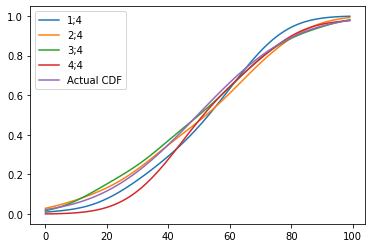

In [6]:
values = np.linspace(-2,2,num=100)

values_from_one_four = [CDF_from_one_four(x) for x in values]
values_from_two_four = [CDF_from_two_four(x) for x in values]
values_from_three_four = [CDF_from_three_four(x) for x in values]
values_from_four_four = [CDF_from_four_four(x) for x in values]

plt.plot(values_from_one_four, label="1;4")
plt.plot(values_from_two_four, label="2;4")
plt.plot(values_from_three_four, label="3;4")
plt.plot(values_from_four_four, label="4;4")

plt.plot(stats.norm.cdf(values), label="Actual CDF")

plt.legend()

Following Haile & Tamer, the lower bound is given by the estimated CDF of the fourth order statistic. We compute the upper bound first using a weighted average and plot both bounds:

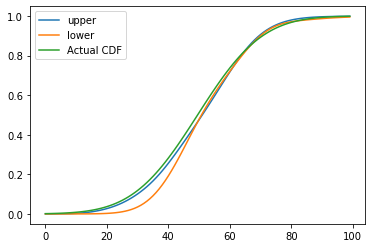

In [7]:
values = np.linspace(-3,3,num=100)

def smooth_upper_bound(x, p):
    all_values = [CDF_from_one_four(x), CDF_from_two_four(x), CDF_from_three_four(x), CDF_from_four_four(x)]
    total = sum([np.exp(g*p) for g in all_values if g >= 0])
    result = sum([g*np.exp(g*p) for g in all_values if g >= 0])/total
    return result

upper_bound_values = [smooth_upper_bound(x, 0) for x in values]
lower_bound_values = [CDF_from_four_four(x) for x in values]

plt.plot(upper_bound_values, label="upper")
plt.plot(lower_bound_values, label="lower")

plt.plot(stats.norm.cdf(values), label="Actual CDF")

plt.legend()

We now want to make sure we can compute the mean of a distribution given its CDF, which is nontrivial because the CDF can be arbitrarily shaped given it is estimated using kernels. To do this, we define a class inheriting from `scipy.stats.rv_continuous`, which has a built-in method that calculates the mean. We speed up this process by overriding the CDF, PDF and PPF of the class, using a discretised version of the CDF which speeds up the calculation.

In [8]:
class FastMean(stats.rv_continuous):
    
    def __init__(self, discrete_cdf, values):
        super().__init__()
        self.discrete_cdf = discrete_cdf
        
    def _cdf(self, x):
        cdf = interpolate.interp1d(values, self.discrete_cdf, bounds_error=False, fill_value=(0,1))
        return cdf(x)
    
    def _ppf(self, y):
        ppf = interpolate.interp1d(self.discrete_cdf, values, bounds_error=False, fill_value="extrapolate")
        return ppf(y)

Let's check how long it takes to calculate the mean of the upper and lower bounds:

In [9]:
start = time.time()

upper_discrete_cdf = [smooth_upper_bound(x, 0) for x in values]
lower_discrete_cdf = [CDF_from_four_four(x) for x in values]

upper_rv = FastMean(upper_discrete_cdf, values)
lower_rv = FastMean(lower_discrete_cdf, values)

print(f"upper estimate: {lower_rv.mean()}")
print(f"lower estimate: {upper_rv.mean()}")

end = time.time()

print(f"Took {end-start} seconds")

/Users/liumukun/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1695: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


upper estimate: 0.16144603084151365
lower estimate: 0.05325017348506063
Took 6.571346282958984 seconds


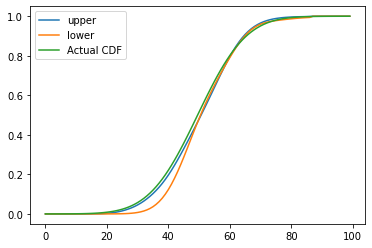

In [10]:
alt_val = np.linspace(-4,4,num=100)

upper_bound_values = [upper_rv.cdf(x) for x in alt_val]
lower_bound_values = [lower_rv.cdf(x) for x in alt_val]

plt.plot(upper_bound_values, label="upper")
plt.plot(lower_bound_values, label="lower")

plt.plot(stats.norm.cdf(alt_val), label="Actual CDF")

plt.legend()

Clearly, here the expectation is not point identified.